In [1]:
from pathlib import Path

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-07-24 11:51:38.620837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 11:51:38.651638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 11:51:38.661079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 11:51:38.682583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 11:51:40.112616: W tensorflow/compiler/tf2

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Create Datasets

The datasets are created using the federated dataset for optimal comparability. The training time is a littlebit slower than with the `tensorflow_datasets` version, but the accuracy is roughly the same (difference of ~2% that I would attribute to randomness)

In [3]:
DATASET = "svhn_cropped"
SVHN_NUM_CLASSES = 10
SVHN_IMAGE_SHAPE = (32, 32, 3)

In [4]:
train_ds, val_ds = tfds.load(DATASET, split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load(DATASET, split='test')
len(train_ds), len(val_ds), len(test_ds)

2024-07-24 11:51:44.073302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 602 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:28:00.0, compute capability: 7.5


(58606, 14651, 26032)

(<matplotlib.image.AxesImage at 0x1472ec363790>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

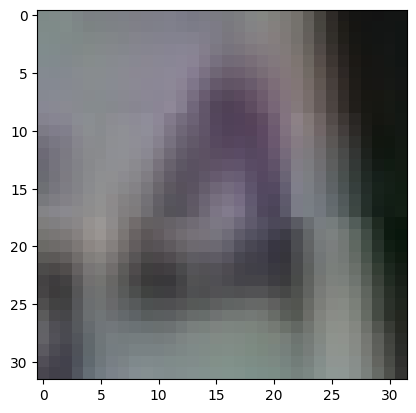

In [5]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [6]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3, value_range=(0.,1.)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor=(-0.3,0.3))
])

In [22]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        # image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            # .repeat(3)
            # .map(lambda x, y: (augmentation(x), y))  # augmentation doesn't really help
            .batch(16)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(16)
        )

In [19]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

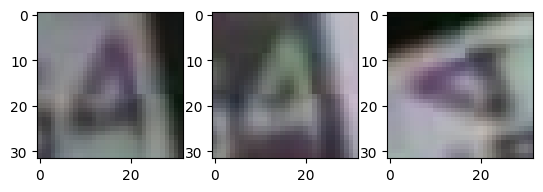

In [9]:
img = next(iter(train_ds))['image']
augmented_img = augmentation(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(tf.image.adjust_contrast(img, -1.1))
axes[2].imshow(augmented_img)

## Models

In [10]:
from models import get_lucasnet, get_simple_cnn, get_mobilenet, get_efficientnet

In [11]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy on {DATASET}')
    plt.show()

### Simple Convolutional Model

In [12]:
model = get_simple_cnn(SVHN_IMAGE_SHAPE, SVHN_NUM_CLASSES)

Epoch 1/100


I0000 00:00:1721814725.150179 1469639 service.cc:146] XLA service 0x14727c005640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721814725.150224 1469639 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-07-24 11:52:05.208323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 11:52:05.501542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-24 11:52:08.315285: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibil

  46/3663 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.1945 - loss: 2.2557 

I0000 00:00:1721814729.378255 1469639 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3663/3663 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.4237 - loss: 1.6633 - val_accuracy: 0.8311 - val_loss: 0.5765
Epoch 2/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7988 - loss: 0.6543 - val_accuracy: 0.8617 - val_loss: 0.4721
Epoch 3/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8314 - loss: 0.5556 - val_accuracy: 0.8705 - val_loss: 0.4311
Epoch 4/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8434 - loss: 0.5107 - val_accuracy: 0.8803 - val_loss: 0.4063
Epoch 5/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8522 - loss: 0.4858 - val_accuracy: 0.8768 - val_loss: 0.4103
Epoch 6/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8562 - loss: 0.4690 - val_accuracy: 0.8883 - val_loss: 0.3739
Epoch 7/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8631 - loss: 0.4491 - val_accuracy: 0.8821 - val_loss: 0.3898
Epoch 8/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8667 - loss: 0.435

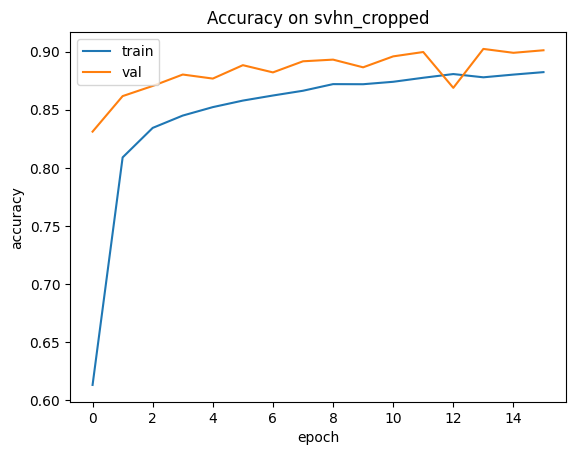

In [13]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### LL Architecture

In [14]:
model = get_lucasnet(SVHN_IMAGE_SHAPE, SVHN_NUM_CLASSES)

Epoch 1/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.6145 - loss: 1.2098 - val_accuracy: 0.8721 - val_loss: 0.4404
Epoch 2/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8623 - loss: 0.4572 - val_accuracy: 0.8906 - val_loss: 0.3818
Epoch 3/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8971 - loss: 0.3479 - val_accuracy: 0.8991 - val_loss: 0.3503
Epoch 4/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9178 - loss: 0.2743 - val_accuracy: 0.9045 - val_loss: 0.3305
Epoch 5/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9387 - loss: 0.2114 - val_accuracy: 0.9100 - val_loss: 0.3251
Epoch 6/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9542 - loss: 0.1610 - val_accuracy: 0.9094 - val_loss: 0.3250
Epoch 7/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9643 - loss: 0.1261 - val_accuracy: 0.9104 - val_loss: 0.3290
Epoch 8/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9734 -

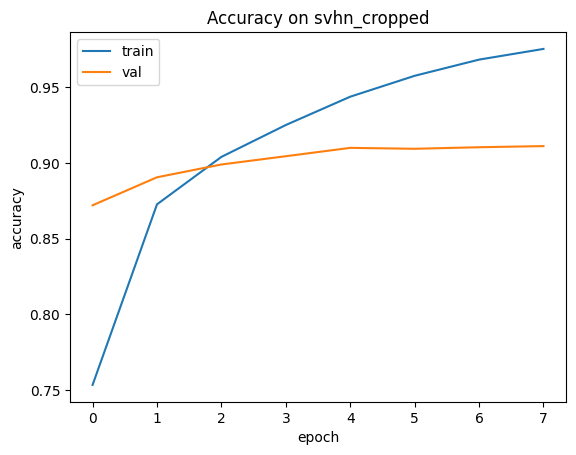

In [15]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)